In [1]:
import pandas as pd
import requests
import json
import time
import grequests
import numpy as np
from PIL import Image
import urllib.request
import colorsys
from ast import literal_eval
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from config import api_key

pd.set_option('display.max_columns', None) 

C:\Users\Varsha\Anaconda3\lib\site-packages\grequests.py:21: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util (C:\\Users\\Varsha\\Anaconda3\\lib\\site-packages\\urllib3\\util\\__init__.py)', 'urllib3.contrib.pyopenssl (C:\\Users\\Varsha\\Anaconda3\\lib\\site-packages\\urllib3\\contrib\\pyopenssl.py)']. 
  curious_george.patch_all(thread=False, select=False)


In [2]:
movie_data = pd.read_csv("Movies_Data_Updated.csv")
movie_data.head()

,Unnamed: 0,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,...,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website
0,0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",...,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN
1,1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",...,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN
2,2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN
3,3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",...,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN
4,4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",...,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN


In [3]:
movie_data = movie_data.drop(movie_data.loc[movie_data["Movie Title"] != movie_data["Title"], :].index)
unclean_data = movie_data.loc[movie_data["Movie Title"] != movie_data["Title"], :]
unclean_data

,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website


In [4]:
dups = pd.concat(g for _, g in movie_data.groupby("Movie Title") if len(g) > 1)
dups

,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website
5351,4-Mar,11-Sep,1.0,18-Jul,"$7,046",29,Emp.,6.0,"$127,035",2003,11-Sep,Unrated,11-Sep-02,134 min,Drama,"Youssef Chahine, Amos Gitai, Shôhei Imamura, A...","Alain Brigand (original idea), Youssef Chahine...","Maryam Karimi, Mohamad Dolati, Agelem Habibi, ...",Eleven directors from 11 countries each contri...,"English, Spanish, French, Arabic, Hebrew, Pers...","UK, France, Egypt, Japan, Mexico, USA, Iran",3 wins & 1 nomination.,https://m.media-amazon.com/images/M/MV5BMzkxMj...,"[{'Source': 'Internet Movie Database', 'Value'...",61.0,7.0,"5,206",tt0328802,26-Oct-04,NaN,Empire Pictures,http://www.empirepicturesusa.com/ep/show_movie...
13606,10-Sep,11-Sep,425.0,8-Sep,"$170,000",37,ADC,425.0,"$170,000",2017,11-Sep,TV-PG,10-Mar-02,112 min,Documentary,"James Hanlon, Gédéon Naudet, Jules Naudet","Tom Forman, Greg Kandra","Tony Benatatos, Jamal Braithwaite, Steve Busce...","On September 11, 2001, filmmaker James Hanlon ...",English,"USA, France",Won 2 Primetime Emmys. Another 6 wins & 6 nomi...,https://m.media-amazon.com/images/M/MV5BMTIyMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,8.4,"6,005",tt0312318,12-Sep-02,NaN,Goldfish Pictures,NaN
8871,20-May,Bluebeard,1.0,26-Mar,"$8,370",32,Strand,3.0,"$33,490",2010,Bluebeard,APPROVED,11-Nov-44,72 min,"Crime, Film-Noir, Horror",Edgar G. Ulmer,"Arnold Lipp (story), Werner H. Furst (story), ...","John Carradine, Jean Parker, Nils Asther, Ludw...","A killer of young women, dubbed Bluebeard, is ...",English,USA,NaN,https://images-na.ssl-images-amazon.com/images...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.0,"1,358",tt0036653,29-Jun-04,NaN,PRC Pictures Inc.,NaN
13242,30-Mar,Bluebeard,14.0,17-Mar,"$21,234",40,WGUSA,14.0,"$43,144",2017,Bluebeard,APPROVED,11-Nov-44,72 min,"Crime, Film-Noir, Horror",Edgar G. Ulmer,"Arnold Lipp (story), Werner H. Furst (story), ...","John Carradine, Jean Parker, Nils Asther, Ludw...","A killer of young women, dubbed Bluebeard, is ...",English,USA,NaN,https://images-na.ssl-images-amazon.com/images...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.0,"1,358",tt0036653,29-Jun-04,NaN,PRC Pictures Inc.,NaN
5113,11-Sep,Chaos,3.0,29-Jan,"$20,570",20,NYer,5.0,"$206,789",2003,Chaos,R,15-Dec-05,106 min,"Action, Crime, Drama, Thriller",Tony Giglio,Tony Giglio,"Jason Statham, Ryan Phillippe, Wesley Snipes, ...","In Seattle, detective Quentin Conners is unfai...",English,"Canada, UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTc3ND...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.5,"48,528",tt0402910,19-Feb-08,NaN,Rogue Pictures,http://www.tfmdistribution.fr/fiches_films/cha...
6406,-,Chaos,NaN,10-Aug,NaN,43,Din.,2.0,"$10,289",2005,Chaos,R,15-Dec-05,106 min,"Action, Crime, Drama, Thriller",Tony Giglio,Tony Giglio,"Jason Statham, Ryan Phillippe, Wesley Snipes, ...","In Seattle, detective Quentin Conners is unfai...",English,"Canada, UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTc3ND...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.5,"48,528",tt0402910,19-Feb-08,NaN,Rogue Pictures,http://www.tfmdistribution.fr/fiches_films/cha...
5223,31-Jul,City of Ghosts,6.0,25-Apr,"$30,547",24,UA,20.0,"$357,197",2003,City of Ghosts,R,27-Mar-03,116 min,"Crime, Drama, Thriller",Matt Dillon,"Matt Dillon, Barry Gifford","Matt Dillon, James Caan, Natascha McElhone, Gé...",A con man flees to Southeast Asia when an inte...,"English, French, Khmer, Russian",USA,NaN,https://m.media-amazon.com/images/M/MV5BMTE5OD...,"[{'Source': 'Internet Movie Database', 'Value'...",57.0,6.0,"4,688",tt0164003,28-Oct-03,"$275,998",MGM Pictures,http://www.cityofghostsmovie.com
13477,7-Sep,City of Ghosts,2.0,7-Jul,"$13,601",23,IFC,18.0,"$128,015",2017,City of Ghosts,R,27-Mar-03,116 min,"Crime

In [5]:
def appendData(reqs):
    for index, row in enumerate(dups.itertuples()):
            try:
                item = reqs[index].json()
                movie_data.at[row.Index, "Title"] = item['Title'] 
                movie_data.at[row.Index, "Rated"] = item['Rated'] 
                movie_data.at[row.Index, "Released"] = item['Released'] 
                movie_data.at[row.Index, "Runtime"] = item['Runtime'] 
                movie_data.at[row.Index, "Genre"] = item['Genre'] 
                movie_data.at[row.Index, "Director"] = item['Director'] 
                movie_data.at[row.Index, "Writer"] = item['Writer'] 
                movie_data.at[row.Index, "Actors"] = item['Actors'] 
                movie_data.at[row.Index, "Plot"] = item['Plot'] 
                movie_data.at[row.Index, "Language"] = item['Language'] 
                movie_data.at[row.Index, "Country"] = item['Country'] 
                movie_data.at[row.Index, "Awards"] = item['Awards'] 
                movie_data.at[row.Index, "Poster"] = item['Poster'] 
                movie_data.at[row.Index, "Ratings"] = item['Ratings'] 
                movie_data.at[row.Index, "Metascore"] = item['Metascore'] 
                movie_data.at[row.Index, "imdbRating"] = item['imdbRating'] 
                movie_data.at[row.Index, "imdbVotes"] = item['imdbVotes'] 
                movie_data.at[row.Index, "imdbID"] = item['imdbID'] 
                movie_data.at[row.Index, "DVD"] = item['DVD'] 
                movie_data.at[row.Index, "BoxOffice"] = item['BoxOffice'] 
                movie_data.at[row.Index, "Production"] = item['Production'] 
                movie_data.at[row.Index, "Website"] = item['Website'] 

            except: 
                print("Record not found")

In [6]:
def exception_handler(request, exception):
    print("Request failed")

urls = ["http://www.omdbapi.com/?t={0}&y={1}&plot=full&apikey={2}".format(row[2].replace(" ", "+"), row[10], api_key) for row in dups.itertuples()]
rs = (grequests.get(u) for u in urls)
requests = grequests.map(rs, exception_handler=exception_handler, size=10)
appendData(requests)

Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found
Record not found


In [7]:
movie_data = movie_data.drop(movie_data.loc[movie_data["Movie Title"] != movie_data["Title"], :].index)
movie_data = movie_data.reset_index(drop=True)
movie_data

,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website
0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",1982,Vice Squad,R,22-Jan-82,97 min,"Action, Crime, Drama",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","Season Hubley, Gary Swanson, Wings Hauser, Pep...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN
1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",1982,The Seduction,R,29-Jan-82,104 min,Thriller,David Schmoeller,David Schmoeller,"Morgan Fairchild, Michael Sarrazin, Vince Edwa...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN
2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",1982,Shoot the Moon,R,19-Feb-82,124 min,Drama,Alan Parker,Bo Goldman,"Albert Finney, Diane Keaton, Karen Allen, Pete...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN
3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",1982,The Border,R,12-Feb-82,108 min,"Crime, Drama",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","Jack Nicholson, Harvey Keitel, Valerie Perrine...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN
4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",1982,Venom,PG-13,5-Oct-18,112 min,"Action, Sci-Fi, Thriller",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","Tom Hardy, Michelle Williams, Riz Ahmed, Scott...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN
5,NaN,"I, the Jury",NaN,9-Jan,NaN,7,Fox,NaN,"$1,515,578",1982,"I, the Jury",R,22-Apr-82,111 min,"Crime, Drama, Mystery, Romance, Thriller",Richard T. Heffron,"Mickey Spillane (novel), Larry Cohen (screenplay)","Armand Assante, Barbara Carrera, Laurene Lando...",An old friend of a private detective is murder...,English,USA,NaN,https://m.media-amazon.com/images/M/MV5BMmJjY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,5.9,"1,258",tt0084112,26-Jul-90,NaN,Fox,NaN
6,NaN,Quest for Fire,223.0,12-Feb,"$2,171,303",1,Fox,426.0,"$20,959,585",1982,Quest for Fire,R,12-Feb-82,100 min,"Adventure, Drama, History",Jean-Jacques Annaud,"Gérard Brach (screenplay), J.H. Rosny Sr. (bas...","Everett McGill, Ron Perlman, Nicholas Kadi, Ra...",Anthony Burgess created the primitive language...,"None, French","Canada, France",Won 1 Oscar. Another 10 wins & 7 nominations.,https://m.media-amazon.com/images/M/MV5BNzIwMG...,"[{'Source': 'Internet Movie Database', 'Value'...",79.0,7.4,"18,752",tt0082484,4-Mar-03,NaN,Fox,NaN
7,NaN,Death Wish II,377.0,19-Feb,"$1,871,487",2,Film,377.0,"$16,100,000",1982,Death Wish II,R,19-Feb-82,89 min,"Action, Crime, Drama, Thriller",Michael Winner,"David Engelbach, Brian Garfield (characters)","Charles Bronson, Jill Ireland, Vincent Gardeni...","Paul Kersey, the vigilante, now lives in LA wi...",English,USA,2 nominations.,https://m.media-amazon.com/im

In [8]:
movie_data["Actors"] = [[actor.strip() for actor in actors.split(",")] if pd.notna(actors) else float('nan') for actors in movie_data["Actors"]]
movie_data["Genre"] = [[genre.strip() for genre in genres.split(",")] if pd.notna(genres) else float('nan') for genres in movie_data["Genre"]]                                   
movie_data

,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website
0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",1982,Vice Squad,R,22-Jan-82,97 min,"[Action, Crime, Drama]",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","[Season Hubley, Gary Swanson, Wings Hauser, Pe...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN
1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",1982,The Seduction,R,29-Jan-82,104 min,[Thriller],David Schmoeller,David Schmoeller,"[Morgan Fairchild, Michael Sarrazin, Vince Edw...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN
2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",1982,Shoot the Moon,R,19-Feb-82,124 min,[Drama],Alan Parker,Bo Goldman,"[Albert Finney, Diane Keaton, Karen Allen, Pet...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN
3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",1982,The Border,R,12-Feb-82,108 min,"[Crime, Drama]",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","[Jack Nicholson, Harvey Keitel, Valerie Perrin...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN
4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",1982,Venom,PG-13,5-Oct-18,112 min,"[Action, Sci-Fi, Thriller]",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","[Tom Hardy, Michelle Williams, Riz Ahmed, Scot...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN
5,NaN,"I, the Jury",NaN,9-Jan,NaN,7,Fox,NaN,"$1,515,578",1982,"I, the Jury",R,22-Apr-82,111 min,"[Crime, Drama, Mystery, Romance, Thriller]",Richard T. Heffron,"Mickey Spillane (novel), Larry Cohen (screenplay)","[Armand Assante, Barbara Carrera, Laurene Land...",An old friend of a private detective is murder...,English,USA,NaN,https://m.media-amazon.com/images/M/MV5BMmJjY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,5.9,"1,258",tt0084112,26-Jul-90,NaN,Fox,NaN
6,NaN,Quest for Fire,223.0,12-Feb,"$2,171,303",1,Fox,426.0,"$20,959,585",1982,Quest for Fire,R,12-Feb-82,100 min,"[Adventure, Drama, History]",Jean-Jacques Annaud,"Gérard Brach (screenplay), J.H. Rosny Sr. (bas...","[Everett McGill, Ron Perlman, Nicholas Kadi, R...",Anthony Burgess created the primitive language...,"None, French","Canada, France",Won 1 Oscar. Another 10 wins & 7 nominations.,https://m.media-amazon.com/images/M/MV5BNzIwMG...,"[{'Source': 'Internet Movie Database', 'Value'...",79.0,7.4,"18,752",tt0082484,4-Mar-03,NaN,Fox,NaN
7,NaN,Death Wish II,377.0,19-Feb,"$1,871,487",2,Film,377.0,"$16,100,000",1982,Death Wish II,R,19-Feb-82,89 min,"[Action, Crime, Drama, Thriller]",Michael Winner,"David Engelbach, Brian Garfield (characters)","[Charles Bronson, Jill Ireland, Vincent Garden...","Paul Kersey, the vigilante, now lives in LA wi...",English,USA,2 nominations.,https://m.med

In [9]:
genres = ["Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", 
            "Documentary", "Drama", "Family", "Fantasy", "Film Noir", "History", "Horror",
            "Music", "Musical", "Mystery", "Romance", "Sci-Fi", "Short", "Sport", "Superhero", 
            "Thriller", "War", "Western"]    
    
for movie in movie_data.itertuples():
    try:
        for genre in genres:
            if genre in movie[15]:
                movie_data.at[movie.Index, genre] = 1
            else: 
                movie_data.at[movie.Index, genre] = 0
    except:
        pass
    
movie_data

,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western
0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",1982,Vice Squad,R,22-Jan-82,97 min,"[Action, Crime, Drama]",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","[Season Hubley, Gary Swanson, Wings Hauser, Pe...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",1982,The Seduction,R,29-Jan-82,104 min,[Thriller],David Schmoeller,David Schmoeller,"[Morgan Fairchild, Michael Sarrazin, Vince Edw...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",1982,Shoot the Moon,R,19-Feb-82,124 min,[Drama],Alan Parker,Bo Goldman,"[Albert Finney, Diane Keaton, Karen Allen, Pet...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",1982,The Border,R,12-Feb-82,108 min,"[Crime, Drama]",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","[Jack Nicholson, Harvey Keitel, Valerie Perrin...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",1982,Venom,PG-13,5-Oct-18,112 min,"[Action, Sci-Fi, Thriller]",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","[Tom Hardy, Michelle Williams, Riz Ahmed, Scot...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,NaN,"I, the Jury",NaN,9-Jan,NaN,7,Fox,NaN,"$1,515,578",1982,"I, the Jury",R,22-Apr-82,111 min,"[Crime, Drama, Mystery, Romance, Thriller]",Richard T. Heffron,"Mickey Spillane (novel), Larry Cohen (screenplay)","[Armand Assante, Barbara Carrera, Laurene Land...",An old friend of a private detective is murder...,English,USA,NaN,https://m.media-amazon.com/images/M/MV5BMmJjY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,5.9,"1,258",tt0084112,26-Jul-90,NaN,Fox,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,NaN,Quest for Fire,223.0,12-Feb,"$2,171,303",1,Fox,426.0,"$20,959,585",1982,Quest for Fire,R,12-Feb-82,100 min,"[Adventure, Drama, H

In [12]:
actors_df = pd.read_csv("Actors_Data.csv")
actors_df.head()

,Unnamed: 0,Person,Total Gross,Number of Movies,Average,#1 Picture,Gross
0,0,Amy Adams,2.402900e+09,30,$80.1,Batman v Superman,330400000.0
1,1,Ben Affleck,2.517800e+09,39,$64.6,Batman v Superman,330400000.0
2,2,Casey Affleck,9.228000e+08,24,$38.4,Interstellar,188000000.0
3,3,Dianna Agron,1.322000e+08,5,$26.4,I Am Number Four,55100000.0
4,4,Jessica Alba,9.523000e+08,24,$39.7,Fantastic Four (2005),154700000.0


In [13]:
for row in movie_data.itertuples():
        counter_tg = 0
        counter_nm = 0
        counter_g = 0
        counter_a = 0
        
        try:
            
#             print(actors_df.loc[actors_df["Person"] == row[18][0], "Total Gross"].item())
            actor_one_tg = actors_df.loc[actors_df["Person"] == row[18][0], "Total Gross"].item()
            actor_one_nm = actors_df.loc[actors_df["Person"] == row[18][0], "Number of Movies"].item()
            actor_one_g = actors_df.loc[actors_df["Person"] == row[18][0], "Gross"].item()
            
            counter_tg = counter_tg + actor_one_tg
            counter_nm = counter_nm + actor_one_nm
            counter_g = counter_g + actor_one_g
            counter_a = counter_a + 1

        except:
            pass
        
        try:
#             print(actors_df.loc[actors_df["Person"] == row[18][1], "Total Gross"].item())
            actor_two_tg = actors_df.loc[actors_df["Person"] == row[18][1], "Total Gross"].item()
            actor_two_nm = actors_df.loc[actors_df["Person"] == row[18][1], "Number of Movies"].item()
            actor_two_g = actors_df.loc[actors_df["Person"] == row[18][1], "Gross"].item()
            
            counter_tg = counter_tg + actor_two_tg
            counter_nm = counter_nm + actor_two_nm
            counter_g = counter_g + actor_two_g
            counter_a = counter_a + 1
            
        except:
            pass
        
        try:
#             print(actors_df.loc[actors_df["Person"] == row[18][2], "Total Gross"].item())
            actor_three_tg = actors_df.loc[actors_df["Person"] == row[18][2], "Total Gross"].item()
            actor_three_nm = actors_df.loc[actors_df["Person"] == row[18][2], "Number of Movies"].item()
            actor_three_g = actors_df.loc[actors_df["Person"] == row[18][2], "Gross"].item()
            
            counter_tg = counter_tg + actor_three_tg
            counter_nm = counter_nm + actor_three_nm
            counter_g = counter_g + actor_three_g
            counter_a = counter_a + 1
            
        except:
            pass
        
        try:
#             print(actors_df.loc[actors_df["Person"] == row[18][3], "Total Gross"].item())
            actor_four_tg = actors_df.loc[actors_df["Person"] == row[18][3], "Total Gross"].item()
            actor_four_nm = actors_df.loc[actors_df["Person"] == row[18][3], "Number of Movies"].item()
            actor_four_g = actors_df.loc[actors_df["Person"] == row[18][3], "Gross"].item()
            
            counter_tg = counter_tg + actor_four_tg
            counter_nm = counter_nm + actor_four_nm
            counter_g = counter_g + actor_four_g
            counter_a = counter_a + 1
           
        except:
            pass
       
        if counter_tg != 0:
            movie_data.at[row.Index, "Actors Avg Total Gross"] = counter_tg/ counter_a
            movie_data.at[row.Index, "Actors Avg Number of Movies"] = counter_nm/ counter_a
            movie_data.at[row.Index, "Actors Avg Best Picture Gross"] = counter_g/ counter_a
        
movie_data       

,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western,Actors Avg Total Gross,Actors Avg Number of Movies,Actors Avg Best Picture Gross
0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",1982,Vice Squad,R,22-Jan-82,97 min,"[Action, Crime, Drama]",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","[Season Hubley, Gary Swanson, Wings Hauser, Pe...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",1982,The Seduction,R,29-Jan-82,104 min,[Thriller],David Schmoeller,David Schmoeller,"[Morgan Fairchild, Michael Sarrazin, Vince Edw...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN
2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",1982,Shoot the Moon,R,19-Feb-82,124 min,[Drama],Alan Parker,Bo Goldman,"[Albert Finney, Diane Keaton, Karen Allen, Pet...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.307800e+09,38.000000,135000000.0
3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",1982,The Border,R,12-Feb-82,108 min,"[Crime, Drama]",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","[Jack Nicholson, Harvey Keitel, Valerie Perrin...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.796000e+09,34.000000,251200000.0
4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",1982,Venom,PG-13,5-Oct-18,112 min,"[Action, Sci-Fi, Thriller]",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","[Tom Hardy, Michelle Williams, Riz Ahmed, Scot...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.417600e+09,25.500000,341500000.0
5,NaN,"I, the Jury",NaN,9-Jan,NaN,7,Fox,NaN,"$1,515,578",1982,"I, the Jury",R,22-Apr-82,111 min,"[Crime, Drama, Mystery, Romance, Thriller]",Richard T. Heffron,"Mickey Spillane (novel), Larry Cohen (screenplay)","[Armand Assante, Barbara Carrera, Laurene Land...",An old friend of a private detective is murder...,English,USA,NaN,https://m.media-amazon.com/images/M/MV5BMmJjY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,5.9,"1,258",tt0084112,26-Jul-90,NaN,Fox,NaN,0.0,0.0,0.0,0.0,0.0,

In [2]:
directors_df = pd.read_csv("director.csv")
directors_df.head()

,Average,BestPic_Gross,Best_Picture,DirectorName,No_Of_Movies,Total_Gross,_id
0,$3.0,$4.4,Flash of Genius,Marc Abraham,2,$6.1,5cbf57e7f1b3f84eb09ba402
1,$43.5,$83.5,Airplane!,Jim Abrahams,8,$348.0,5cbf57e7f1b3f84eb09ba403
2,$336.8,$936.7,Star Wars: The Force Awakens,J.J. Abrams,5,"$1,684.2",5cbf57e7f1b3f84eb09ba404
3,$192.5,$441.2,Shrek 2,Andrew Adamson,6,"$1,154.7",5cbf57e7f1b3f84eb09ba405
4,$5.8,$5.8,Bordello of Blood,Gilbert Adler,1,$5.8,5cbf57e7f1b3f84eb09ba406


In [3]:
for col in ['Total_Gross','BestPic_Gross', 'Average']:
    directors_df[col]= directors_df[col].replace({'\$': '',',': ''}, regex=True)
    directors_df[col]=[ float(x.replace('k', "")) * 1000 if 'k' in x else float(x)* 1000000  for x in directors_df[col]]
    
directors_df.head()

,Average,BestPic_Gross,Best_Picture,DirectorName,No_Of_Movies,Total_Gross,_id
0,3000000.0,4400000.0,Flash of Genius,Marc Abraham,2,6.100000e+06,5cbf57e7f1b3f84eb09ba402
1,43500000.0,83500000.0,Airplane!,Jim Abrahams,8,3.480000e+08,5cbf57e7f1b3f84eb09ba403
2,336800000.0,936700000.0,Star Wars: The Force Awakens,J.J. Abrams,5,1.684200e+09,5cbf57e7f1b3f84eb09ba404
3,192500000.0,441200000.0,Shrek 2,Andrew Adamson,6,1.154700e+09,5cbf57e7f1b3f84eb09ba405
4,5800000.0,5800000.0,Bordello of Blood,Gilbert Adler,1,5.800000e+06,5cbf57e7f1b3f84eb09ba406


In [4]:
directors_df = directors_df.drop(columns=['_id'])
directors_df.head()

,Average,BestPic_Gross,Best_Picture,DirectorName,No_Of_Movies,Total_Gross
0,3000000.0,4400000.0,Flash of Genius,Marc Abraham,2,6.100000e+06
1,43500000.0,83500000.0,Airplane!,Jim Abrahams,8,3.480000e+08
2,336800000.0,936700000.0,Star Wars: The Force Awakens,J.J. Abrams,5,1.684200e+09
3,192500000.0,441200000.0,Shrek 2,Andrew Adamson,6,1.154700e+09
4,5800000.0,5800000.0,Bordello of Blood,Gilbert Adler,1,5.800000e+06


In [5]:
directors_df.dtypes
directors_df.to_csv("directors.csv", index=False)

In [26]:
movie_data = movie_data.merge(directors_df[['Total_Gross','No_Of_Movies', 'BestPic_Gross','DirectorName']], left_on='Director', right_on='DirectorName', how='left')
movie_data


,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western,Actors Avg Total Gross,Actors Avg Number of Movies,Actors Avg Best Picture Gross,Total_Gross,No_Of_Movies,BestPic_Gross,DirectorName
0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",1982,Vice Squad,R,22-Jan-82,97 min,"[Action, Crime, Drama]",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","[Season Hubley, Gary Swanson, Wings Hauser, Pe...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",1982,The Seduction,R,29-Jan-82,104 min,[Thriller],David Schmoeller,David Schmoeller,"[Morgan Fairchild, Michael Sarrazin, Vince Edw...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",1982,Shoot the Moon,R,19-Feb-82,124 min,[Drama],Alan Parker,Bo Goldman,"[Albert Finney, Diane Keaton, Karen Allen, Pet...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.307800e+09,38.000000,135000000.0,NaN,NaN,NaN,NaN
3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",1982,The Border,R,12-Feb-82,108 min,"[Crime, Drama]",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","[Jack Nicholson, Harvey Keitel, Valerie Perrin...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.796000e+09,34.000000,251200000.0,NaN,NaN,NaN,NaN
4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",1982,Venom,PG-13,5-Oct-18,112 min,"[Action, Sci-Fi, Thriller]",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","[Tom Hardy, Michelle Williams, Riz Ahmed, Scot...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.417600e+09,25.500000,341500000.0,372200000.0,4.0,213500000.0,Ruben Fleischer
5,NaN,"I, the Jury",NaN,9-Jan,NaN,7,Fox,NaN,"$1,515,578",1982,"I, the Jury",R,22-Apr-82,111 min,"[Crime, Drama, Mystery, Romance, Thriller]",Richard T. Heffron,"Mickey Spillane (novel), Larry Cohen (screenplay)","[Armand Assante, Barbara Carrera, Laurene Land...",An old friend of a private detective is murder...,English,USA,NaN,https://m.

In [27]:
movie_data = movie_data.rename(columns={"Total_Gross": "Director Total Gross", "No_Of_Movies": "Director Number of Movies", "BestPic_Gross" : "Director Best Picture Gross" }).drop(columns=['DirectorName'])
movie_data

,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western,Actors Avg Total Gross,Actors Avg Number of Movies,Actors Avg Best Picture Gross,Director Total Gross,Director Number of Movies,Director Best Picture Gross
0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",1982,Vice Squad,R,22-Jan-82,97 min,"[Action, Crime, Drama]",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","[Season Hubley, Gary Swanson, Wings Hauser, Pe...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",1982,The Seduction,R,29-Jan-82,104 min,[Thriller],David Schmoeller,David Schmoeller,"[Morgan Fairchild, Michael Sarrazin, Vince Edw...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",1982,Shoot the Moon,R,19-Feb-82,124 min,[Drama],Alan Parker,Bo Goldman,"[Albert Finney, Diane Keaton, Karen Allen, Pet...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.307800e+09,38.000000,135000000.0,NaN,NaN,NaN
3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",1982,The Border,R,12-Feb-82,108 min,"[Crime, Drama]",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","[Jack Nicholson, Harvey Keitel, Valerie Perrin...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.796000e+09,34.000000,251200000.0,NaN,NaN,NaN
4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",1982,Venom,PG-13,5-Oct-18,112 min,"[Action, Sci-Fi, Thriller]",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","[Tom Hardy, Michelle Williams, Riz Ahmed, Scot...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.417600e+09,25.500000,341500000.0,372200000.0,4.0,213500000.0
5,NaN,"I, the Jury",NaN,9-Jan,NaN,7,Fox,NaN,"$1,515,578",1982,"I, the Jury",R,22-Apr-82,111 min,"[Crime, Drama, Mystery, Romance, Thriller]",Richard T. Heffron,"Mickey Spillane (novel), Larry Cohen (screenplay)","[Armand Assante, Barbara Carrera, Laurene Land...",An old friend of a private detective is murder...,English,USA,NaN,https://m.media-ama

In [30]:
movie_titles = movie_data["Movie Title"].tolist()
movie_titles

['Vice Squad',
 'The Seduction',
 'Shoot the Moon',
 'The Border',
 'Venom',
 'I, the Jury',
 'Quest for Fire',
 'Death Wish II',
 'Missing',
 'Making Love',
 'Das Boot',
 'Night Crossing',
 'The Beast Within',
 'The Amateur',
 'Personal Best',
 'Cannery Row',
 'Barbarosa',
 'One from the Heart',
 'Love and Money',
 "Porky's",
 'Richard Pryor: Live on the Sunset Strip',
 'Victor/Victoria',
 'Deathtrap',
 'Diner',
 'I Ought to Be in Pictures',
 'Evil Under the Sun',
 "I'm Dancing as Fast as I Can",
 'The Sword and the Sorcerer',
 'Some Kind of Hero',
 'Silent Rage',
 'If You Could See What I Hear',
 'Cat People',
 'Partners',
 'Penitentiary II',
 'A Little Sex',
 'Rocky III',
 'Annie',
 'Conan the Barbarian',
 'The Road Warrior',
 "Dead Men Don't Wear Plaid",
 'Visiting Hours',
 'Paradise',
 'Wrong Is Right',
 'Fighting Back',
 'The House Where Evil Dwells',
 'The Escape Artist',
 'Star Trek II: The Wrath of Khan',
 'Poltergeist',
 'Firefox',
 'Blade Runner',
 'Grease 2',
 'Author! Auth

In [41]:
analyzer = SentimentIntensityAnalyzer()
vs_list = [analyzer.polarity_scores(title) for title in movie_titles]

movie_data["Title Negative Sentiment"] = [vs["neg"] for vs in vs_list]
movie_data["Title Neutral Sentiment"] = [vs["neu"] for vs in vs_list]
movie_data["Title Positive Sentiment"] = [vs["pos"] for vs in vs_list]
movie_data["Title Compound Sentiment"] = [vs["compound"] for vs in vs_list]

movie_data.head()

,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western,Actors Avg Total Gross,Actors Avg Number of Movies,Actors Avg Best Picture Gross,Director Total Gross,Director Number of Movies,Director Best Picture Gross,Title Negative Sentiment,Title Neutral Sentiment,Title Positive Sentiment,Title Compound Sentiment
0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",1982,Vice Squad,R,22-Jan-82,97 min,"[Action, Crime, Drama]",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","[Season Hubley, Gary Swanson, Wings Hauser, Pe...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.0,0.00
1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",1982,The Seduction,R,29-Jan-82,104 min,[Thriller],David Schmoeller,David Schmoeller,"[Morgan Fairchild, Michael Sarrazin, Vince Edw...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.0,0.00
2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",1982,Shoot the Moon,R,19-Feb-82,124 min,[Drama],Alan Parker,Bo Goldman,"[Albert Finney, Diane Keaton, Karen Allen, Pet...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.307800e+09,38.0,135000000.0,NaN,NaN,NaN,0.545,0.455,0.0,-0.34
3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",1982,The Border,R,12-Feb-82,108 min,"[Crime, Drama]",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","[Jack Nicholson, Harvey Keitel, Valerie Perrin...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.796000e+09,34.0,251200000.0,NaN,NaN,NaN,0.000,1.000,0.0,0.00
4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",1982,Venom,PG-13,5-Oct-18,112 min,"[Action, Sci-Fi, Thriller]",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","[Tom Hardy, Michelle Williams, Riz Ahmed, Scot...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.417600e+09,25.5,341500000.0,372200000.0,4.0,213500000.0,0.000,1.000,0.0,0.00


In [248]:
def most_frequent_colour(url):
    
    try:                                           
        resp = urllib.request.urlopen(url)
        image = Image.open(resp)
        w, h = image.size
        pixels = image.getcolors(w * h)

        most_frequent_pixel = pixels[0]

        for count, colour in pixels:
            if count > most_frequent_pixel[0]:
                most_frequent_pixel = (count, colour)
        peak = most_frequent_pixel[1]

        HLS = colorsys.rgb_to_hls(peak[0]/255.0,peak[1]/255.0,peak[2]/255.0)

        hueAngle = HLS[0]*360

        # Lightness
        if (HLS[1] < 0.2):
            myDominantColor = "Black"
        elif (HLS[1] > 0.8):
            myDominantColor = "White"
        # saturation
        elif (HLS[2] < 0.25):
            myDominantColor = "Gray"
        # hue
        elif (hueAngle < 30):
            myDominantColor = "Red"
        elif (hueAngle < 90):
            myDominantColor = "Yellow"
        elif (hueAngle < 150):
            myDominantColor = "Green"
        elif (hueAngle < 210):
            myDominantColor = "Cyan"
        elif (hueAngle < 270):
            myDominantColor = "Blue"
        elif (hueAngle < 330):
            myDominantColor = "Magenta"
        else:
            myDominantColor = "Red"

        return myDominantColor
    
    except:
        return float('nan')

# na_action='ignore'
movie_data['Poster Color'] = movie_data["Poster"].apply(most_frequent_colour)


(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(255, 255, 253)
(6, 1, 7)
(0, 0, 0)
(0, 0, 0)
(14, 14, 14)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(145, 144, 150)
(242, 231, 185)
(255, 255, 250)
(249, 249, 247)
(47, 40, 47)
(230, 230, 230)
(255, 255, 250)
(55, 49, 49)
(255, 252, 247)
(18, 17, 22)
(249, 214, 247)
(255, 253, 248)
(2, 3, 31)
(255, 255, 255)
(240, 232, 221)
(0, 0, 0)
(30, 30, 28)
(4, 10, 8)
(0, 0, 0)
(255, 255, 255)
(22, 22, 22)
(0, 0, 0)
(245, 245, 243)
(4, 4, 4)
(38, 39, 44)
(35, 31, 30)
(16, 12, 11)
(13, 12, 17)
(164, 165, 170)
(255, 255, 253)
(6, 8, 5)
(0, 0, 0)
(21, 21, 19)
(10, 4, 16)
(0, 0, 0)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(4, 0, 0)
(1, 127, 214)
(59, 56, 51)
(255, 255, 255)
(236, 238, 235)
(233, 230, 225)
(236, 220, 205)
(15, 12, 31)
(255, 255, 255)
(255, 255, 255)
(245, 238, 220)
255
(242, 222, 172)
(238, 238, 236)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(227, 226, 208)
(12, 7, 3)
(0, 0, 0)
(43, 27, 63)
(25, 24, 29)
(9, 5, 4)
(17, 17, 17)
(

(227, 235, 238)
(18, 19, 23)
(4, 4, 4)
(255, 255, 253)
(30, 25, 21)
(251, 248, 241)
(0, 139, 224)
(32, 22, 23)
(255, 255, 255)
(2, 3, 8)
14
(255, 254, 255)
(55, 32, 40)
(249, 249, 249)
(255, 255, 255)
(14, 14, 14)
(255, 255, 255)
(253, 253, 253)
(255, 255, 255)
(0, 0, 0)
(39, 33, 47)
(21, 17, 18)
(255, 255, 253)
(32, 26, 70)
(9, 3, 17)
(24, 20, 19)
(16, 19, 12)
(0, 0, 0)
(196, 221, 252)
(29, 24, 30)
(244, 0, 2)
(6, 4, 15)
(0, 0, 9)
(235, 236, 228)
(252, 249, 244)
(6, 6, 6)
(255, 255, 255)
(13, 12, 17)
(22, 0, 2)
(29, 29, 27)
(255, 251, 252)
(0, 0, 0)
(0, 0, 0)
(25, 0, 92)
(0, 0, 0)
(7, 1, 1)
(0, 0, 0)
(46, 52, 84)
(255, 255, 255)
(0, 0, 0)
(0, 0, 4)
(255, 255, 243)
(32, 31, 36)
(209, 78, 50)
(0, 0, 0)
(13, 13, 13)
(255, 255, 255)
(0, 0, 0)
(148, 40, 53)
(18, 13, 19)
(0, 0, 0)
(248, 248, 246)
(248, 213, 145)
(24, 19, 26)
(255, 255, 255)
(255, 255, 255)
(255, 255, 255)
(7, 6, 11)
(28, 24, 25)
(0, 0, 0)
(2, 2, 2)
(0, 0, 0)
(255, 255, 255)
(255, 255, 250)
(250, 250, 250)
(54, 128, 223)
(21

(255, 255, 253)
(17, 12, 18)
(21, 16, 23)
(13, 13, 11)
(8, 8, 8)
(231, 199, 152)
(255, 181, 204)
(3, 3, 3)
(0, 0, 0)
(213, 33, 32)
(5, 5, 5)
(4, 0, 0)
(20, 15, 21)
(73, 44, 88)
(46, 35, 39)
(255, 255, 255)
(252, 249, 244)
(13, 12, 17)
(4, 4, 4)
(255, 253, 248)
(0, 0, 0)
(29, 25, 26)
(109, 138, 156)
(255, 255, 255)
(55, 73, 155)
(11, 7, 8)
(1, 34, 101)
(233, 233, 233)
(0, 0, 0)
(1, 9, 12)
(221, 222, 217)
(223, 223, 223)
(255, 255, 255)
(255, 255, 255)
(230, 222, 211)
(4, 4, 4)
(14, 14, 14)
(35, 31, 30)
(1, 0, 16)
(7, 1, 1)
(3, 3, 3)
(24, 20, 21)
(17, 13, 14)
(18, 12, 12)
(13, 12, 17)
(0, 0, 0)
(16, 11, 17)
(0, 0, 4)
(252, 252, 252)
(43, 70, 137)
(249, 226, 112)
(27, 22, 28)
(36, 30, 30)
(238, 238, 238)
(245, 220, 119)
(25, 20, 26)
(2, 2, 2)
(22, 18, 19)
(0, 0, 0)
(64, 74, 83)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(255, 255, 255)
(137, 36, 28)
(238, 231, 202)
(255, 255, 255)
(49, 37, 87)
(7, 7, 5)
(227, 227, 227)
(3, 5, 4)
(11, 11, 11)
(255, 255, 253)
(255, 255, 255)
(214, 49, 117)
(179, 23, 27)

(10, 6, 7)
(18, 17, 22)
(245, 246, 240)
(255, 255, 255)
(25, 22, 17)
(213, 27, 2)
(4, 0, 0)
(2, 2, 2)
(0, 0, 0)
(255, 255, 255)
(13, 13, 23)
(255, 255, 255)
(11, 11, 11)
(255, 255, 248)
(38, 40, 61)
(0, 0, 0)
(11, 7, 6)
(3, 3, 3)
(226, 230, 215)
(15, 15, 15)
(255, 255, 255)
(176, 173, 154)
(0, 0, 4)
(0, 0, 0)
(10, 32, 131)
(42, 83, 135)
(0, 0, 0)
(24, 19, 26)
(0, 117, 204)
(255, 255, 255)
(1, 147, 186)
(253, 253, 253)
(255, 248, 232)
(255, 255, 255)
(2, 2, 2)
(31, 23, 47)
(31, 26, 33)
(25, 14, 10)
(0, 0, 0)
(255, 254, 255)
(0, 0, 0)
(0, 93, 188)
(14, 23, 6)
(222, 227, 231)
(245, 246, 250)
(252, 255, 255)
(230, 210, 199)
(15, 15, 15)
(255, 255, 253)
(255, 255, 255)
(255, 255, 255)
(236, 233, 216)
(15, 15, 13)
(0, 0, 0)
(17, 17, 17)
(2, 2, 2)
(0, 0, 0)
(255, 169, 50)
(28, 22, 24)
(0, 0, 0)
(216, 221, 225)
(0, 0, 4)
(254, 212, 3)
(255, 255, 255)
(255, 255, 255)
(25, 0, 58)
(2, 1, 6)
(8, 7, 12)
(24, 10, 1)
(32, 31, 36)
(50, 104, 254)
(83, 73, 71)
(251, 252, 255)
(0, 0, 0)
(0, 0, 0)
(235, 2

(248, 248, 248)
(27, 28, 32)
(27, 30, 63)
(0, 0, 0)
(253, 249, 248)
(26, 25, 30)
(22, 18, 19)
(22, 21, 26)
(4, 3, 1)
(238, 32, 42)
(1, 11, 38)
(14, 17, 10)
(163, 163, 173)
(15, 15, 15)
(63, 99, 133)
(10, 10, 10)
(254, 250, 239)
(67, 111, 58)
(255, 255, 255)
(255, 255, 255)
(6, 6, 6)
(253, 197, 0)
(6, 5, 10)
(15, 16, 10)
(28, 26, 37)
(37, 20, 30)
(91, 73, 53)
(22, 18, 17)
(2, 2, 2)
(15, 9, 13)
(0, 0, 0)
(20, 15, 21)
(252, 252, 252)
(253, 253, 253)
(13, 14, 19)
(7, 3, 4)
(14, 11, 6)
(0, 0, 0)
(49, 61, 109)
(255, 255, 255)
(225, 226, 230)
(56, 65, 168)
(255, 255, 250)
(236, 235, 204)
(104, 100, 101)
(255, 255, 253)
(0, 18, 22)
(30, 29, 34)
(29, 19, 9)
(255, 255, 255)
(255, 255, 255)
(11, 8, 3)
(28, 30, 29)
(2, 2, 2)
(255, 255, 243)
(253, 253, 253)
(40, 39, 115)
(0, 0, 0)
(0, 0, 0)
(4, 4, 4)
(25, 26, 21)
(255, 255, 255)
(216, 181, 1)
(248, 245, 238)
(14, 9, 16)
(27, 23, 22)
(7, 6, 11)
(252, 251, 255)
(191, 54, 62)
(255, 255, 1)
(190, 158, 109)
(255, 255, 244)
(0, 0, 0)
(3, 3, 3)
(1, 3, 2)


(11, 11, 11)
(0, 0, 4)
(2, 2, 2)
(35, 35, 37)
(4, 4, 4)
(0, 0, 0)
(25, 20, 26)
(17, 17, 15)
(48, 33, 14)
(208, 200, 3)
(25, 24, 29)
(0, 0, 4)
(13, 13, 13)
(5, 13, 16)
(0, 0, 0)
(253, 253, 253)
(255, 255, 255)
(0, 0, 0)
(253, 253, 253)
(255, 255, 255)
(22, 22, 22)
(252, 255, 234)
(37, 31, 31)
(26, 27, 21)
(21, 20, 25)
(191, 237, 252)
(10, 10, 8)
(255, 211, 2)
(255, 254, 255)
(0, 0, 0)
(9, 5, 6)
(12, 8, 9)
(50, 48, 113)
(255, 255, 255)
(18, 14, 13)
(24, 27, 42)
(247, 243, 244)
(2, 3, 8)
(2, 2, 2)
(14, 15, 19)
(255, 255, 255)
(0, 0, 0)
(20, 21, 25)
(3, 5, 4)
(0, 0, 0)
(255, 251, 250)
(226, 143, 91)
(6, 6, 4)
(31, 21, 19)
(255, 255, 255)
(1, 43, 81)
(6, 5, 10)
(252, 252, 252)
(255, 255, 253)
(246, 246, 246)
(255, 248, 2)
(255, 255, 255)
(71, 149, 234)
(254, 254, 254)
(255, 255, 255)
(3, 0, 0)
(255, 255, 253)
(255, 255, 255)
(4, 4, 4)
(242, 243, 247)
(0, 0, 0)
(252, 180, 42)
(13, 13, 13)
(0, 0, 0)
(45, 33, 35)
(3, 5, 4)
(252, 252, 252)
(244, 237, 221)
(5, 1, 2)
(0, 0, 0)
(3, 6, 21)
(6, 5, 1

(0, 0, 0)
(2, 2, 2)
(80, 188, 234)
(237, 50, 57)
(0, 0, 0)
(249, 248, 253)
(29, 30, 25)
(252, 239, 3)
(255, 255, 255)
(4, 4, 4)
(22, 23, 18)
(0, 0, 0)
(241, 78, 95)
(13, 13, 13)
(233, 235, 234)
(254, 255, 255)
(14, 14, 12)
(2, 2, 2)
(229, 241, 237)
(30, 24, 26)
(255, 255, 255)
(2, 2, 2)
(255, 255, 255)
(18, 18, 28)
(255, 255, 255)
(0, 0, 0)
(31, 36, 56)
(249, 248, 253)
(255, 255, 255)
(3, 0, 0)
(0, 0, 0)
(71, 130, 174)
(255, 51, 34)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(18, 19, 23)
(1, 2, 6)
(253, 253, 251)
(24, 14, 12)
(2, 2, 2)
(4, 3, 8)
(5, 5, 5)
(247, 248, 252)
(0, 0, 0)
(252, 252, 250)
(245, 246, 248)
(255, 254, 255)
(18, 7, 11)
(70, 129, 187)
(255, 255, 255)
(91, 77, 136)
(255, 255, 253)
(5, 7, 6)
(238, 238, 238)
(23, 11, 13)
(8, 8, 8)
(32, 33, 35)
(13, 13, 13)
(2, 1, 6)
(10, 10, 20)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(20, 21, 16)
(6, 5, 1)
(0, 0, 0)
(255, 255, 255)
(255, 254, 255)
(223, 223, 223)
(252, 172, 1)
(255, 255, 255)
(23, 25, 22)
(0, 0, 0)
(255, 255, 255)
(181, 212, 241)
(255

(30, 30, 30)
(1, 1, 3)
(10, 9, 15)
(33, 49, 101)
(255, 255, 223)
(31, 32, 37)
(255, 255, 255)
(0, 0, 0)
(255, 255, 255)
(28, 28, 28)
(255, 255, 255)
(253, 253, 253)
(255, 255, 255)
(2, 2, 2)
(255, 255, 255)
(0, 0, 0)
(254, 255, 255)
(91, 74, 80)
(255, 255, 255)
(191, 224, 241)
(118, 206, 228)
(253, 253, 253)
(0, 0, 0)
(20, 15, 21)
(248, 220, 77)
(13, 4, 7)
(0, 0, 0)
(0, 0, 0)
(44, 45, 50)
(39, 35, 36)
(188, 167, 166)
(228, 235, 243)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(231, 84, 41)
(39, 39, 39)
(44, 35, 26)
(255, 255, 255)
(10, 6, 5)
(0, 0, 0)
(3, 7, 32)
(1, 2, 6)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(13, 14, 18)
(0, 0, 0)
(26, 32, 58)
(255, 254, 255)
(0, 0, 0)
(61, 56, 62)
(3, 51, 87)
(0, 0, 0)
(255, 255, 255)
(231, 231, 231)
(0, 0, 0)
(6, 0, 2)
(26, 30, 93)
(255, 255, 255)
(17, 22, 25)
(1, 9, 32)
(255, 255, 255)
(44, 44, 44)
(21, 10, 14)
(237, 242, 222)
(2, 3, 7)
(0, 0, 0)
(0, 1, 0)
(0, 0, 0)
(255, 255, 25

(86, 4, 6)
(255, 255, 255)
(2, 4, 3)
(35, 31, 32)
(255, 255, 255)
(7, 7, 7)
(0, 0, 0)
(11, 11, 13)
(0, 0, 0)
(2, 10, 13)
(249, 214, 2)
(255, 255, 255)
(2, 2, 2)
(0, 11, 33)
(255, 241, 46)
(253, 252, 255)
(251, 251, 251)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(247, 250, 243)
(0, 0, 0)
(255, 255, 255)
(20, 16, 15)
(255, 255, 255)
(17, 13, 12)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(239, 232, 160)
(255, 255, 255)
(0, 0, 0)
(182, 172, 59)
(0, 0, 0)
(12, 6, 6)
(255, 255, 255)
(91, 190, 221)
(23, 21, 43)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(1, 1, 1)
(255, 255, 255)
(18, 18, 18)
(10, 7, 2)
(0, 0, 0)
(152, 209, 238)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 108, 165)
(255, 255, 255)
(11, 10, 15)
(0, 0, 0)
(25, 26, 20)
(255, 255, 255)
(25, 14, 20)
(255, 255, 255)
(50, 48, 35)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(255, 255, 255)
(0, 0, 0)
(5, 0, 7)
(253, 241, 215)
(255, 255, 255)
(255, 255, 255)
(31, 1, 3)
(190, 85, 190)
(5, 6, 10)
(0, 0, 0)
(163, 166, 123)
(1, 3, 0)
(0, 0, 0)
(

(250, 250, 250)
(0, 0, 0)
(0, 255, 247)
(255, 255, 255)
(220, 232, 244)
(2, 4, 1)
(2, 2, 2)
(216, 25, 33)
(4, 0, 0)
(220, 9, 54)
(84, 55, 47)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(85, 97, 111)
(141, 208, 216)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(15, 5, 3)
(249, 249, 247)
(253, 253, 253)
(255, 255, 255)
(0, 0, 0)
(13, 12, 17)
(0, 0, 0)
(243, 239, 227)
(255, 255, 255)
(13, 13, 13)
(6, 5, 10)
(0, 0, 0)
(26, 21, 27)
(255, 255, 255)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(131, 150, 156)
(254, 254, 254)
(248, 248, 248)
(2, 1, 7)
(0, 0, 0)
(21, 0, 1)
(229, 221, 210)
(6, 2, 1)
(255, 255, 255)
(136, 200, 225)
(15, 19, 28)
(75, 152, 208)
(36, 0, 0)
(70, 164, 190)
(255, 255, 255)
(255, 255, 255)
(0, 0, 2)
(255, 255, 255)
(255, 255, 255)
(4, 0, 0)
(255, 255, 255)
(0, 0, 0)
(255, 255, 255)
(242, 203, 63)
(0, 0, 0)
(247, 255, 255)
(255, 255, 255)
(251, 234, 226)
(4, 4, 4)
(255, 255, 255)
(255, 255, 255)
(9, 9, 21)
(7, 9, 8)
(246, 170, 206)
(0, 0, 0)
(241, 209, 158)
(6, 2, 1)
(255, 74, 79)
(0, 0, 0

(141, 142, 146)
(255, 255, 255)
(242, 242, 242)
(254, 230, 230)
(0, 0, 0)
(0, 0, 0)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(255, 255, 255)
(0, 0, 0)
(255, 255, 255)
(228, 228, 228)
(5, 6, 10)
(7, 7, 7)
(255, 255, 255)
(255, 255, 255)
(0, 0, 5)
(255, 255, 255)
(255, 255, 255)
(246, 172, 189)
(3, 2, 7)
(255, 255, 255)
(249, 251, 250)
(3, 0, 0)
(0, 0, 0)
(0, 0, 0)
(238, 192, 80)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(221, 207, 194)
(4, 3, 8)
(8, 8, 8)
(255, 210, 3)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(255, 255, 255)
(0, 0, 0)
(237, 248, 254)
(255, 255, 255)
(232, 194, 149)
(1, 1, 1)
(0, 0, 0)
(0, 0, 0)
(9, 5, 6)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(0, 1, 0)
(0, 0, 0)
193
(218, 225, 235)
(6, 6, 6)
(0, 0, 0)
(2, 3, 8)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(250, 242, 221)
(212, 27, 33)
(0, 0, 0)
(21, 19, 66)
(0, 0, 0)
(19, 18, 24)
(253, 252, 255)
(0, 0, 0)
(255, 255, 255)
(202, 219, 229)
(255, 255, 255)
(0, 0, 0)
(255, 255, 255)
(19, 19, 19)
(0, 0, 0)
(255, 255, 255)
(22, 

(255, 254, 255)
(0, 0, 0)
(255, 255, 253)
(255, 255, 255)
(255, 255, 255)
(231, 232, 234)
(255, 255, 255)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(253, 253, 251)
(255, 255, 255)
(0, 0, 0)
(44, 57, 65)
(255, 255, 255)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(241, 242, 236)
(255, 255, 255)
(255, 255, 255)
(3, 3, 3)
(0, 80, 191)
(0, 0, 0)
(3, 3, 3)
(252, 187, 41)
(0, 1, 0)
(253, 253, 253)
(0, 0, 0)
(71, 127, 160)
(0, 0, 0)
(0, 183, 241)
(18, 17, 22)
(255, 254, 255)
(253, 249, 248)
(0, 0, 0)
(18, 18, 16)
(254, 201, 7)
(245, 246, 240)
(0, 0, 0)
(188, 184, 173)
(255, 255, 250)
(174, 197, 205)
(0, 0, 0)
(255, 255, 255)
(4, 0, 0)
(253, 253, 251)
(3, 0, 0)
(41, 41, 41)
(38, 43, 63)
(255, 255, 255)
(0, 0, 0)
(46, 126, 189)
(245, 249, 250)
(0, 0, 0)
(2, 1, 7)
(0, 0, 0)
(9, 0, 0)
(0, 0, 0)
(29, 24, 20)
(255, 255, 255)
(0, 0, 0)
(255, 255, 248)
(166, 148, 128)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(100, 195, 253)
(3, 0, 0)
(0, 0, 0)
(23, 24, 28)
(4, 4, 4)
(0, 0, 4)
(5, 7, 6)
(103, 124, 

(5, 6, 10)
(0, 0, 0)
(248, 239, 234)
(15, 118, 195)
(0, 0, 0)
(207, 140, 70)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(239, 239, 239)
(0, 0, 0)
(242, 249, 255)
(235, 26, 58)
(0, 0, 0)
(0, 0, 0)
(27, 34, 42)
(0, 0, 0)
(9, 10, 15)
(6, 0, 0)
(1, 0, 18)
(254, 254, 254)
(0, 0, 0)
(0, 0, 0)
(0, 0, 0)
(255, 255, 255)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(8, 8, 8)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(229, 225, 214)
(134, 134, 134)
(73, 23, 14)
(25, 15, 16)
(255, 255, 255)
(249, 245, 244)
(255, 255, 255)
(71, 84, 54)
(255, 255, 255)
(231, 222, 205)
(255, 255, 255)
(255, 255, 255)
(5, 6, 10)
(222, 216, 194)
(0, 0, 0)
(250, 151, 34)
(248, 245, 238)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(7, 9, 8)
(246, 122, 36)
(255, 237, 199)
(0, 0, 0)
(255, 255, 255)
(0, 0, 0)
(237, 248, 254)
(254, 222, 15)
(252, 166, 27)
(0, 0, 0)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(255, 255, 255)
(6, 8, 7)
(0, 0, 0)
(92, 109, 125)
(0, 0, 0)
(241, 31, 40)
(18, 20, 17)
(7, 8, 12)
(254, 225, 191)
(231, 237,

(240, 245, 249)
(255, 255, 255)
(255, 255, 255)
(255, 255, 255)
(254, 212, 3)
(243, 243, 243)
(4, 127, 194)
(6, 2, 1)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(249, 234, 203)
(255, 255, 250)
(0, 5, 0)
(14, 19, 23)
(0, 0, 0)
(237, 27, 36)
(128, 22, 26)
(255, 255, 255)
(255, 255, 253)
(4, 4, 4)
(197, 39, 30)
(208, 130, 29)
(0, 0, 0)
(13, 21, 23)
(255, 255, 255)
(22, 22, 22)
(255, 255, 255)
(0, 0, 0)
(255, 255, 255)
(102, 105, 98)
(237, 236, 241)
(255, 255, 255)
(73, 54, 37)
(92, 112, 145)
(174, 199, 95)
(14, 28, 15)
(231, 231, 231)
(150, 145, 141)
(0, 10, 19)
(0, 0, 0)
(161, 190, 232)
(23, 24, 29)
(0, 0, 0)
(6, 2, 1)
(5, 6, 10)
(5, 6, 10)
(0, 0, 0)
(21, 22, 27)
(22, 14, 27)
(75, 65, 55)
(6, 6, 6)
(1, 1, 1)
(255, 255, 255)
(95, 205, 238)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(255, 255, 255)
(16, 11, 17)
(3, 5, 4)
(0, 0, 0)
(255, 255, 255)
(247, 0, 0)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(0, 1, 0)
(0, 0, 0)
(129, 23, 23)
(75, 159, 206)
(255, 255, 255)
(18, 18, 18)
(222, 225, 218)
(251,

(0, 0, 0)
(0, 0, 0)
(246, 243, 226)
(26, 22, 11)
(255, 255, 255)
(213, 203, 193)
(226, 231, 234)
(211, 211, 211)
(9, 10, 14)
(255, 255, 255)
(194, 20, 22)
(8, 0, 18)
(11, 11, 11)
(0, 0, 0)
(255, 255, 255)
(0, 0, 0)
(0, 0, 0)
(255, 255, 255)
(162, 0, 0)
(0, 0, 0)
(1, 0, 0)
(234, 234, 234)
(255, 255, 255)
(70, 121, 204)
(0, 0, 0)
(4, 0, 0)
(254, 214, 64)
(29, 28, 33)
(0, 0, 0)
(2, 1, 6)
(11, 11, 11)
(229, 220, 205)
(222, 219, 214)
(255, 254, 255)
(5, 1, 2)
(0, 0, 0)
(0, 1, 0)
(0, 0, 0)
(255, 255, 255)
(53, 52, 50)
(252, 252, 252)
(253, 251, 203)
(244, 240, 239)
(23, 23, 23)
(5, 1, 0)
(255, 255, 255)
(243, 239, 227)
(183, 213, 215)
(231, 232, 226)
(0, 0, 0)
(10, 12, 11)
(6, 11, 15)
(0, 0, 0)
(0, 0, 0)
(5, 1, 2)
(0, 0, 0)
(0, 0, 0)
(11, 12, 16)
(255, 255, 255)
(255, 255, 255)
(238, 238, 238)
(0, 0, 0)
(255, 255, 255)
(106, 16, 16)
(255, 255, 255)
(255, 255, 255)
(252, 242, 243)
(18, 7, 5)
(76, 66, 64)
(0, 0, 0)
(0, 0, 0)
(0, 6, 0)
(0, 0, 0)
(1, 2, 6)
(29, 8, 7)
(255, 255, 255)
(179, 143, 1

(255, 255, 255)
(0, 0, 0)
(5, 6, 10)
(249, 255, 255)
(2, 2, 2)
(255, 255, 255)
(246, 217, 219)
(6, 23, 43)
(1, 1, 11)
(249, 216, 23)
(255, 255, 255)
(255, 253, 246)
(0, 0, 0)
(255, 255, 255)
(0, 0, 0)
(255, 255, 255)
(3, 3, 15)
(0, 0, 0)
(0, 0, 0)
(29, 124, 144)
(17, 163, 153)
(0, 1, 0)
(2, 2, 2)
(252, 247, 218)
(0, 0, 0)
(0, 0, 0)
(252, 252, 252)
(225, 210, 191)
(2, 19, 26)
(255, 255, 255)
(26, 51, 58)
(20, 0, 100)
(253, 184, 67)
(34, 32, 33)
(250, 250, 250)
(255, 255, 255)
(45, 103, 117)
(196, 79, 70)
(253, 249, 250)
(219, 217, 205)
(0, 0, 0)
(210, 232, 243)
(6, 6, 6)
(10, 6, 7)
(244, 240, 239)
(2, 2, 0)
(0, 0, 0)
(5, 6, 10)
(68, 54, 45)
(254, 255, 255)
(255, 255, 255)
(0, 0, 0)
(255, 255, 255)
(21, 17, 16)
(253, 241, 245)
(230, 234, 243)
(255, 255, 255)
(21, 219, 254)
(8, 8, 8)
(14, 65, 130)
(255, 255, 255)
(18, 26, 28)
(255, 255, 255)
(245, 249, 234)
(17, 17, 15)
(255, 253, 246)
(242, 239, 232)
(0, 0, 0)
(253, 253, 253)
(0, 0, 0)
(4, 4, 4)
(3, 4, 8)
(235, 235, 235)
(0, 0, 0)
(255, 

(14, 9, 15)
(255, 255, 255)
(0, 1, 0)
(0, 0, 0)
(255, 255, 255)
(21, 17, 18)
(255, 255, 255)
(42, 31, 39)
(0, 0, 0)
(255, 255, 255)
(2, 123, 154)
(0, 2, 0)
(6, 12, 8)
(0, 0, 0)
(221, 197, 169)
(241, 235, 235)
(60, 182, 255)
(73, 139, 151)
(0, 0, 0)
(227, 219, 208)
(3, 0, 0)
(7, 9, 8)
(179, 37, 35)
(65, 70, 73)
(255, 255, 255)
(255, 255, 255)
(0, 0, 0)
(34, 14, 7)
(255, 255, 255)
(255, 255, 255)
(16, 28, 42)
(0, 0, 0)
(5, 1, 0)
(255, 254, 242)
(0, 0, 2)
(0, 0, 0)
(0, 0, 2)
(71, 152, 208)
(9, 43, 55)
(2, 4, 3)
(219, 35, 35)
(255, 255, 255)
(255, 241, 176)
(77, 77, 77)
(255, 255, 255)
(0, 1, 0)
(6, 22, 74)
(240, 236, 227)
(90, 112, 100)
(198, 184, 175)
(134, 125, 120)
(1, 2, 6)
(255, 255, 255)
(0, 0, 0)
(233, 223, 221)
(39, 41, 28)
(4, 4, 4)
(242, 242, 242)
(247, 255, 255)
(229, 222, 203)
(249, 245, 233)
(0, 0, 0)
(253, 253, 253)
(247, 237, 227)
(248, 248, 246)
(137, 174, 252)
(0, 0, 0)
(1, 1, 13)
(242, 242, 244)
(255, 250, 221)
(255, 255, 255)
(226, 227, 231)
(9, 20, 26)
(255, 255, 255)


(255, 255, 255)
(255, 254, 255)
(217, 205, 107)
(233, 244, 246)
(0, 0, 0)
(255, 255, 255)
(235, 166, 73)
(40, 40, 40)
(9, 11, 10)
(14, 14, 14)
(249, 239, 229)
(248, 250, 249)
(255, 255, 255)
(255, 254, 255)
(173, 29, 39)
(6, 7, 11)
(0, 0, 0)
0
(0, 0, 0)
(217, 223, 237)
(255, 255, 255)
(230, 236, 250)
(255, 255, 255)
(8, 8, 8)
(220, 220, 220)
(17, 21, 30)
(48, 48, 48)
(0, 0, 0)
(47, 49, 48)
(13, 17, 26)
(149, 183, 169)
(235, 235, 211)
(5, 1, 2)
(255, 255, 255)
(255, 255, 255)
(22, 17, 13)
(0, 0, 0)
(17, 18, 22)
(0, 0, 0)
(4, 6, 5)
(106, 205, 237)
(0, 179, 237)
(204, 206, 219)
(235, 216, 199)
(4, 3, 9)
(0, 0, 0)
(11, 11, 9)
(255, 255, 255)
(5, 89, 133)
(21, 26, 30)
(201, 213, 225)
(3, 0, 0)
(0, 0, 0)
(255, 255, 255)
(0, 0, 0)
(18, 19, 13)
(0, 0, 0)
(233, 233, 233)
(0, 0, 0)
(246, 246, 244)
(0, 0, 0)
(0, 0, 0)
(37, 33, 34)
(247, 222, 18)
(6, 2, 1)
(255, 255, 255)
(0, 0, 0)
(8, 2, 2)
(236, 33, 39)
(0, 0, 0)
(202, 209, 219)
(11, 11, 11)
(0, 0, 0)
(255, 254, 255)
(105, 105, 115)
(255, 255, 2

(15, 19, 48)
(243, 240, 223)
(201, 0, 107)
(10, 15, 19)
(33, 27, 27)
(207, 204, 199)
(255, 255, 255)
(248, 237, 209)
(255, 255, 255)
(0, 0, 0)
(0, 18, 54)
(1, 3, 2)
(2, 2, 2)
(6, 11, 14)
(255, 255, 255)
(255, 255, 255)
(255, 255, 255)
(0, 0, 4)
(1, 0, 18)
(47, 30, 36)
(95, 36, 68)
(255, 255, 255)
(255, 255, 255)
(255, 255, 250)
(241, 241, 241)
(3, 3, 1)
(6, 0, 0)
(37, 38, 40)
(12, 22, 49)
(225, 227, 224)
(166, 236, 212)
(246, 248, 234)
(6, 6, 4)
(30, 30, 30)
(147, 151, 160)
(34, 14, 25)
(250, 242, 143)
(0, 0, 0)
(27, 10, 52)
(2, 0, 28)
(229, 208, 189)
(0, 0, 0)
(255, 255, 255)
(255, 255, 255)
(153, 55, 28)
(222, 229, 239)
(0, 0, 0)
(7, 7, 7)
(250, 110, 23)
(0, 0, 0)
(223, 49, 48)
(0, 0, 0)
(4, 4, 4)
(231, 61, 2)
(219, 218, 224)
(10, 48, 147)
(249, 221, 0)
(0, 0, 0)
(212, 216, 225)
(0, 0, 0)
(7, 33, 34)
(129, 228, 249)
(0, 0, 0)
(217, 80, 34)
(3, 0, 0)
(233, 229, 218)
(2, 7, 11)
(238, 233, 229)
(0, 0, 0)
(255, 240, 219)
(16, 17, 21)
(239, 237, 176)
(255, 255, 255)
(130, 130, 130)
(42, 5

In [226]:
# import cv2
# faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# img=np.array(image)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# faces = faceCascade.detectMultiScale(
#     gray,
#     scaleFactor=1.3,
#     minNeighbors=5
# )

# print(len(faces))



1


In [1]:
movie_data.to_csv("Movie_Data_Updated.csv")
# movie_data.head()

In [66]:
movie_data_updated = pd.read_csv("Movie_Data_Updated.csv")
movie_data_updated = movie_data_updated.drop(columns=["Unnamed: 0"])
movie_data_updated

,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western,Actors Avg Total Gross,Actors Avg Number of Movies,Actors Avg Best Picture Gross,Director Total Gross,Director Number of Movies,Director Best Picture Gross,Title Negative Sentiment,Title Neutral Sentiment,Title Positive Sentiment,Title Compound Sentiment,Poster Color
0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",1982,Vice Squad,R,22-Jan-82,97 min,"['Action', 'Crime', 'Drama']",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","['Season Hubley', 'Gary Swanson', 'Wings Hause...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.000,0.0000,Black
1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",1982,The Seduction,R,29-Jan-82,104 min,['Thriller'],David Schmoeller,David Schmoeller,"['Morgan Fairchild', 'Michael Sarrazin', 'Vinc...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.000,0.0000,White
2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",1982,Shoot the Moon,R,19-Feb-82,124 min,['Drama'],Alan Parker,Bo Goldman,"['Albert Finney', 'Diane Keaton', 'Karen Allen...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.307800e+09,38.000000,135000000.0,NaN,NaN,NaN,0.545,0.455,0.000,-0.3400,White
3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",1982,The Border,R,12-Feb-82,108 min,"['Crime', 'Drama']",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","['Jack Nicholson', 'Harvey Keitel', 'Valerie P...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.796000e+09,34.000000,251200000.0,NaN,NaN,NaN,0.000,1.000,0.000,0.0000,White
4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",1982,Venom,PG-13,5-Oct-18,112 min,"['Action', 'Sci-Fi', 'Thriller']",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","['Tom Hardy', 'Michelle Williams', 'Riz Ahmed'...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.417600e+09,25.500000,341500000.0,372200000.0,4.0,213500000.0,0.000,1.000,0.000,0.0000,Black
5,NaN,"I, the Jury",NaN,9-Jan,NaN,7,Fox,NaN,"$1,515,578",1982

In [67]:
colors = ["Black", "White", "Gray", "Red", "Yellow", "Green", 
            "Cyan", "Blue", "Magenta"]    
    
for poster in movie_data_updated.itertuples():
#         print(poster[67])
        if pd.notna(poster[67]):
            for color in colors:
                if color == poster[67]:
                    movie_data_updated.at[poster.Index, color] = 1
                else: 
                    movie_data_updated.at[poster.Index, color] = 0
        else:
            float("nan")
    
movie_data_updated

,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western,Actors Avg Total Gross,Actors Avg Number of Movies,Actors Avg Best Picture Gross,Director Total Gross,Director Number of Movies,Director Best Picture Gross,Title Negative Sentiment,Title Neutral Sentiment,Title Positive Sentiment,Title Compound Sentiment,Poster Color,Black,White,Gray,Red,Yellow,Green,Cyan,Blue,Magenta
0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",1982,Vice Squad,R,22-Jan-82,97 min,"['Action', 'Crime', 'Drama']",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","['Season Hubley', 'Gary Swanson', 'Wings Hause...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.000,0.0000,Black,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",1982,The Seduction,R,29-Jan-82,104 min,['Thriller'],David Schmoeller,David Schmoeller,"['Morgan Fairchild', 'Michael Sarrazin', 'Vinc...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.000,0.0000,White,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",1982,Shoot the Moon,R,19-Feb-82,124 min,['Drama'],Alan Parker,Bo Goldman,"['Albert Finney', 'Diane Keaton', 'Karen Allen...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.307800e+09,38.000000,135000000.0,NaN,NaN,NaN,0.545,0.455,0.000,-0.3400,White,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",1982,The Border,R,12-Feb-82,108 min,"['Crime', 'Drama']",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","['Jack Nicholson', 'Harvey Keitel', 'Valerie P...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.796000e+09,34.000000,251200000.0,NaN,NaN,NaN,0.000,1.000,0.000,0.0000,White,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",1982,Venom,PG-13,5-Oct-18,112 min,"['Action', 'Sci-Fi', 'Thriller']",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","['Tom Hardy', 'Michelle Williams', 'Riz Ahmed'...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [68]:
def RottenTomatoesScore(colVal):
    dictRot=literal_eval(colVal)
    if len(dictRot)<1:
        return float('nan')

    try:
        value = dictRot[1]
    except IndexError:
         return float("nan")

    if value["Source"] == 'Rotten Tomatoes':
         return float(value['Value'].replace("%",""))
    else: 
        return float('nan')
    
    

movie_data_updated["Rotten Tomatoes Score"] = movie_data_updated["Ratings"].apply(RottenTomatoesScore )

movie_data_updated.head()


,Close,Movie Title,O Theaters,Open,Opening,Rank,Studio,TG Theaters,Total Gross,Year,Title,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western,Actors Avg Total Gross,Actors Avg Number of Movies,Actors Avg Best Picture Gross,Director Total Gross,Director Number of Movies,Director Best Picture Gross,Title Negative Sentiment,Title Neutral Sentiment,Title Positive Sentiment,Title Compound Sentiment,Poster Color,Black,White,Gray,Red,Yellow,Green,Cyan,Blue,Magenta,Rotten Tomatoes Score
0,NaN,Vice Squad,510.0,22-Jan,"$1,717,205",1,Emb,510.0,"$13,253,583",1982,Vice Squad,R,22-Jan-82,97 min,"['Action', 'Crime', 'Drama']",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","['Season Hubley', 'Gary Swanson', 'Wings Hause...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"1,469",tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.0,0.00,Black,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,NaN,The Seduction,597.0,22-Jan,"$1,503,543",2,Emb,597.0,"$11,378,339",1982,The Seduction,R,29-Jan-82,104 min,['Thriller'],David Schmoeller,David Schmoeller,"['Morgan Fairchild', 'Michael Sarrazin', 'Vinc...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799,tt0084652,7-Nov-06,NaN,Embassy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.0,0.00,White,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,NaN,Shoot the Moon,585.0,22-Jan,"$1,870,000",3,MGM,585.0,"$9,217,530",1982,Shoot the Moon,R,19-Feb-82,124 min,['Drama'],Alan Parker,Bo Goldman,"['Albert Finney', 'Diane Keaton', 'Karen Allen...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,"2,167",tt0084675,6-Nov-07,NaN,Warner Home Video,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.307800e+09,38.0,135000000.0,NaN,NaN,NaN,0.545,0.455,0.0,-0.34,White,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
3,NaN,The Border,84.0,29-Jan,"$516,014",4,Uni.,888.0,"$6,118,683",1982,The Border,R,12-Feb-82,108 min,"['Crime', 'Drama']",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","['Jack Nicholson', 'Harvey Keitel', 'Valerie P...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,"5,316",tt0083678,11-May-04,NaN,Universal Pictures,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.796000e+09,34.0,251200000.0,NaN,NaN,NaN,0.000,1.000,0.0,0.00,White,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0
4,NaN,Venom,900.0,29-Jan,"$1,672,747",5,Par.,900.0,"$5,229,643",1982,Venom,PG-13,5-Oct-18,112 min,"['Action', 'Sci-Fi', 'Thriller']",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","['Tom Hardy', 'Michelle Williams', 'Riz Ahmed'...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,"257,961",tt1270797,18-Jun-13,NaN,Vis,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [69]:
movie_data_updated=movie_data_updated.rename(columns={"Runtime":'Runtime in Min', "Open":"Opening Day Date", 
 "O Theaters":"Opening Theaters", "Opening":"Opening Gross Amount", "TG Theaters":"Total Theaters"})

movie_data_updated["Rank"]=movie_data_updated["Rank"].astype(float)
movie_data_updated["Total Gross"]=movie_data_updated["Total Gross"].replace({'\$': '',',': ''}, regex=True).astype(float)
movie_data_updated["Opening Gross Amount"]=movie_data_updated["Opening Gross Amount"].replace({'\$': '',',': ''}, regex=True).astype(float)
movie_data_updated["imdbVotes"]=movie_data_updated["imdbVotes"].replace({'\$': '',',': ''}, regex=True).astype(float)
movie_data_updated["Runtime in Min"]=movie_data_updated["Runtime in Min"].str.rstrip(" min").astype(float)


In [70]:
movie_data_updated["Good"] =  [1 if x > 7.5 else 0 for x in movie_data_updated["imdbRating"]]
movie_data_updated.head()

,Close,Movie Title,Opening Theaters,Opening Day Date,Opening Gross Amount,Rank,Studio,Total Theaters,Total Gross,Year,Title,Rated,Released,Runtime in Min,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Ratings,Metascore,imdbRating,imdbVotes,imdbID,DVD,BoxOffice,Production,Website,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western,Actors Avg Total Gross,Actors Avg Number of Movies,Actors Avg Best Picture Gross,Director Total Gross,Director Number of Movies,Director Best Picture Gross,Title Negative Sentiment,Title Neutral Sentiment,Title Positive Sentiment,Title Compound Sentiment,Poster Color,Black,White,Gray,Red,Yellow,Green,Cyan,Blue,Magenta,Rotten Tomatoes Score,Good
0,NaN,Vice Squad,510.0,22-Jan,1717205.0,1.0,Emb,510.0,13253583.0,1982,Vice Squad,R,22-Jan-82,97.0,"['Action', 'Crime', 'Drama']",Gary Sherman,"Sandy Howard, Kenneth Peters, Robert Vincent O...","['Season Hubley', 'Gary Swanson', 'Wings Hause...","A Los Angeles businesswoman, known only by her...",English,"UK, USA",NaN,https://m.media-amazon.com/images/M/MV5BMTRhYj...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,1469.0,tt0084861,21-Feb-06,NaN,Anchor Bay Entertainment,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.0,0.00,Black,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
1,NaN,The Seduction,597.0,22-Jan,1503543.0,2.0,Emb,597.0,11378339.0,1982,The Seduction,R,29-Jan-82,104.0,['Thriller'],David Schmoeller,David Schmoeller,"['Morgan Fairchild', 'Michael Sarrazin', 'Vinc...",Los Angeles anchorwoman Jaime Douglas has it a...,English,USA,3 nominations.,https://m.media-amazon.com/images/M/MV5BZDljY2...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,4.9,799.0,tt0084652,7-Nov-06,NaN,Embassy,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1.000,0.0,0.00,White,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0
2,NaN,Shoot the Moon,585.0,22-Jan,1870000.0,3.0,MGM,585.0,9217530.0,1982,Shoot the Moon,R,19-Feb-82,124.0,['Drama'],Alan Parker,Bo Goldman,"['Albert Finney', 'Diane Keaton', 'Karen Allen...","A fifteen year marriage dissolves, leaving bot...",English,USA,Nominated for 2 Golden Globes. Another 5 nomin...,https://m.media-amazon.com/images/M/MV5BZTk2ZW...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,7.0,2167.0,tt0084675,6-Nov-07,NaN,Warner Home Video,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.307800e+09,38.0,135000000.0,NaN,NaN,NaN,0.545,0.455,0.0,-0.34,White,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0
3,NaN,The Border,84.0,29-Jan,516014.0,4.0,Uni.,888.0,6118683.0,1982,The Border,R,12-Feb-82,108.0,"['Crime', 'Drama']",Tony Richardson,"Deric Washburn, Walon Green, David Freeman","['Jack Nicholson', 'Harvey Keitel', 'Valerie P...",U.S. Border Patrol agent Charlie Smith just wa...,"English, Spanish",USA,NaN,https://m.media-amazon.com/images/M/MV5BYmNiMz...,"[{'Source': 'Internet Movie Database', 'Value'...",NaN,6.4,5316.0,tt0083678,11-May-04,NaN,Universal Pictures,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.796000e+09,34.0,251200000.0,NaN,NaN,NaN,0.000,1.000,0.0,0.00,White,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0
4,NaN,Venom,900.0,29-Jan,1672747.0,5.0,Par.,900.0,5229643.0,1982,Venom,PG-13,5-Oct-18,112.0,"['Action', 'Sci-Fi', 'Thriller']",Ruben Fleischer,"Jeff Pinkner (screenplay by), Scott Rosenberg ...","['Tom Hardy', 'Michelle Williams', 'Riz Ahmed'...",A failed reporter is bonded to an alien entity...,"English, Mandarin, Malay","China, USA",NaN,https://m.media-amazon.com/images/M/MV5BNzAwNz...,"[{'Source': 'Internet Movie Database', 'Value'...",35.0,6.8,257961.0,tt1270797,18-Jun-13,NaN,Vis,NaN,1.0,0.0,0.0,0.0,0.

In [71]:
# movie_data_updated.dtypes

In [72]:
movie_data_updated.to_csv("Movie_Data_Final.csv", index=False)

In [73]:
movie_data_updated.count()

Close                             7914
Movie Title                      11875
Opening Theaters                 11190
Opening Day Date                 11875
Opening Gross Amount             11152
Rank                             11875
Studio                           11847
Total Theaters                   11517
Total Gross                      11875
Year                             11875
Title                            11875
Rated                            10472
Released                         11730
Runtime in Min                   11796
Genre                            11839
Director                         11716
Writer                           11133
Actors                           11699
Plot                             11738
Language                         11829
Country                          11872
Awards                            8762
Poster                           11728
Ratings                          11875
Metascore                         8128
imdbRating               

In [74]:
mlone = movie_data_updated[["Good", "Runtime in Min", "Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", 
            "Documentary", "Drama", "Family", "Fantasy", "Film Noir", "History", "Horror",
            "Music", "Musical", "Mystery", "Romance", "Sci-Fi", "Short", "Sport", "Superhero", 
            "Thriller", "War", "Western","Title Compound Sentiment"]].dropna()

mlone = mlone.reset_index(drop=True)

mlone.head()
# movie_data_updated.isnull().sum()

,Good,Runtime in Min,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Short,Sport,Superhero,Thriller,War,Western,Title Compound Sentiment
0,0,97.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,0,104.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00
2,0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.34
3,0,108.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
4,0,112.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00


In [76]:
# mlone.loc[mlone["Good"] ==1]

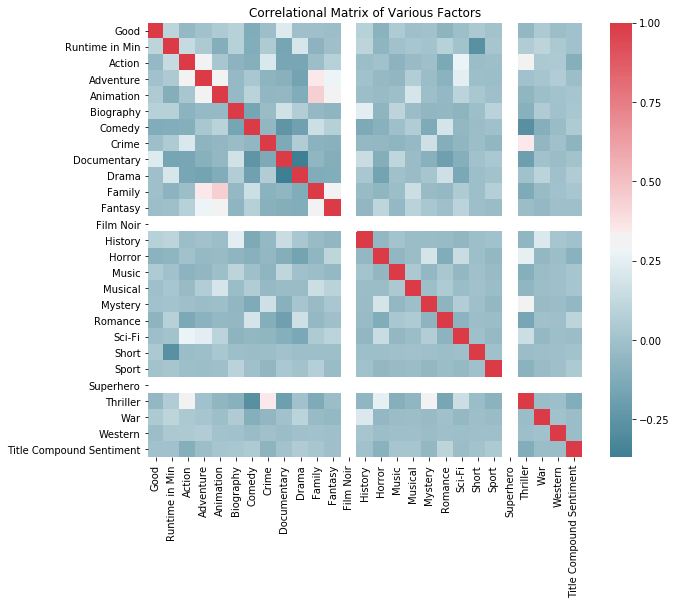

In [77]:
f, ax = plt.subplots(figsize=(10, 8))
corr = mlone.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)                                   


plt.title("Correlational Matrix of Various Factors")
plt.show()

In [78]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = mlone.columns[columns]
mlone = mlone[selected_columns]

In [79]:
# mlone[["Runtime in Min", "Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", 
#             "Documentary", "Drama", "Family", "Fantasy", "Film Noir", "History", "Horror",
#             "Music", "Musical", "Mystery", "Romance", "Sci-Fi", "Short", "Sport", "Superhero", 
#             "Thriller", "War", "Western", "Actors Avg Total Gross", "Actors Avg Number of Movies", 
#             "Actors Avg Best Picture Gross", "Director Total Gross", "Director Number of Movies", "Director Best Picture Gross", 
#             "Title Compound Sentiment", "Black", "White", "Gray", "Red", "Yellow", "Green", 
#             "Cyan", "Blue", "Magenta", "Red", 'Good']].corr()['Good'][:]

In [80]:
X = mlone[["Runtime in Min", "Action", "Adventure", "Animation", "Biography", "Comedy", "Crime", 
            "Documentary", "Drama", "Family", "Fantasy", "Film Noir", "History", "Horror",
            "Music", "Musical", "Mystery", "Romance", "Sci-Fi", "Short", "Sport", "Superhero", 
            "Thriller", "War", "Western", "Title Compound Sentiment"]]
y = mlone[["Good"]].values.reshape(-1, 1)



In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [82]:
from sklearn.preprocessing import StandardScaler 
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [83]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

classifier = LogisticRegression(penalty='l1').fit(X_train, y_train)
classifier

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [85]:
sel = SelectFromModel(classifier, prefit=True)

sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True])

In [86]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8839528558476881
Testing Data Score: 0.8854520734194425


In [88]:
import pickle

filename = "finalized_model.pkl"
pickle.dump(classifier, open(filename, "wb"))

In [89]:
loaded_model = pickle.load(open(filename, "rb"))
result = loaded_model.score(X_test, y_test)
print(result)

0.8854520734194425
